In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/kaggle/input/mpii-human-pose/mpii_human_pose.csv')

In [3]:
data.columns

Index(['ID', 'NAME', 'r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y',
       'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y',
       'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X',
       'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X',
       'l elbow_Y', 'l wrist_X', 'l wrist_Y', 'Scale', 'Activity', 'Category'],
      dtype='object')

<ipython-input-50-b88bc536f3d7>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y = sample[i], sample[i+1]


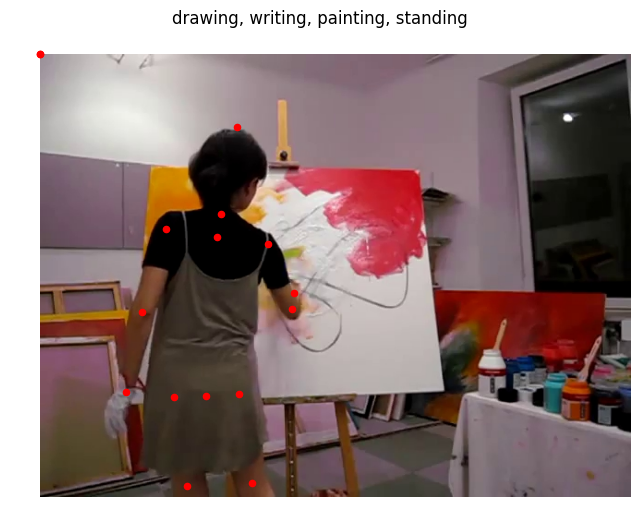

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

df = pd.read_csv("/kaggle/input/mpii-human-pose/mpii_human_pose.csv")
image_dir = "/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/"

import random
random_index = random.randint(0, len(df) - 1)
sample = df.iloc[random_index]
image_path = image_dir + sample["NAME"]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = []
for i in range(2, 34, 2):
    x, y = sample[i], sample[i+1]
    if not pd.isna(x) and not pd.isna(y):
        keypoints.append((int(x), int(y)))

plt.figure(figsize=(8, 8))
plt.imshow(image)
for x, y in keypoints:
    plt.scatter(x, y, c='red', s=20)
plt.title(sample['Activity'])
plt.axis('off')
plt.show()

In [53]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os

class MPIIHumanPoseDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, input_size=(224, 224)):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.input_size = input_size
        self.keypoint_columns = self.df.columns[2:-3]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx]['NAME'])
        image = Image.open(img_name).convert('RGB')
        original_width, original_height = image.size
        resized_image = image.resize(self.input_size)
        new_width, new_height = self.input_size
        keypoints = self.df.iloc[idx][self.keypoint_columns].values.astype('float')
        processed_keypoints = []
        for i in range(0, len(keypoints), 2):
            x = keypoints[i]
            y = keypoints[i+1]
            scaled_x = x * (new_width / original_width)
            scaled_y = y * (new_height / original_height)
            norm_x = scaled_x / (new_width - 1)
            norm_y = scaled_y / (new_height - 1)
            processed_keypoints.extend([norm_x, norm_y])
        if self.transform:
            resized_image = self.transform(resized_image)
        else:
            resized_image = transforms.ToTensor()(resized_image)
        keypoints = torch.tensor(processed_keypoints, dtype=torch.float32)
        return resized_image, keypoints

class KeypointPredictionModel(nn.Module):
    def __init__(self, num_keypoints=32):
        super(KeypointPredictionModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_keypoints),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

BATCH_SIZE = 8
INPUT_SIZE = (224, 224)
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = MPIIHumanPoseDataset(
    csv_file='/kaggle/input/mpii-human-pose/mpii_human_pose.csv',
    img_dir='/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/',
    transform=transform,
    input_size=INPUT_SIZE
)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KeypointPredictionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
from IPython.display import FileLink, display

batch_losses = []

for epoch in range(100):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, keypoints) in enumerate(dataloader, start=1):
        images = images.to(device)
        keypoints = keypoints.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        batch_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

        gc.collect()
    
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] completed, Average Loss: {epoch_loss:.4f}')

    model_path = f'final_model_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), model_path)
    
    print(f'Model for epoch {epoch+1} saved at: {model_path}')
    display(FileLink(model_path))

print('Training completed!')
print('Total batches:', len(batch_losses))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Batch [100/2172], Loss: 0.0431
Epoch [1/100], Batch [200/2172], Loss: 0.0403
Epoch [1/100], Batch [300/2172], Loss: 0.0482
Epoch [1/100], Batch [400/2172], Loss: 0.0423
Epoch [1/100], Batch [500/2172], Loss: 0.0395
Epoch [1/100], Batch [600/2172], Loss: 0.0474
Epoch [1/100], Batch [700/2172], Loss: 0.0426
Epoch [1/100], Batch [800/2172], Loss: 0.0525
Epoch [1/100], Batch [900/2172], Loss: 0.0434
Epoch [1/100], Batch [1000/2172], Loss: 0.0470
Epoch [1/100], Batch [1100/2172], Loss: 0.0602
Epoch [1/100], Batch [1200/2172], Loss: 0.0396
Epoch [1/100], Batch [1300/2172], Loss: 0.0290
Epoch [1/100], Batch [1400/2172], Loss: 0.0392
Epoch [1/100], Batch [1500/2172], Loss: 0.0600
Epoch [1/100], Batch [1600/2172], Loss: 0.0282
Epoch [1/100], Batch [1700/2172], Loss: 0.0333
Epoch [1/100], Batch [1800/2172], Loss: 0.0354
Epoch [1/100], Batch [1900/2172], Loss: 0.0417
Epoch [1/100], Batch [2000/2172], Loss: 0.0633
Epoch [1/100], Batch [2100/2172], Loss: 0.0487
Epoch [1/100] complete

/kaggle/working/final_model_epoch_1.pth

Epoch [2/100], Batch [100/2172], Loss: 0.0685
Epoch [2/100], Batch [200/2172], Loss: 0.0379
Epoch [2/100], Batch [300/2172], Loss: 0.0310
Epoch [2/100], Batch [400/2172], Loss: 0.0335
Epoch [2/100], Batch [500/2172], Loss: 0.0419
Epoch [2/100], Batch [600/2172], Loss: 0.0568
Epoch [2/100], Batch [700/2172], Loss: 0.0623
Epoch [2/100], Batch [800/2172], Loss: 0.0388
Epoch [2/100], Batch [900/2172], Loss: 0.0473
Epoch [2/100], Batch [1000/2172], Loss: 0.0428
Epoch [2/100], Batch [1100/2172], Loss: 0.0226
Epoch [2/100], Batch [1200/2172], Loss: 0.0269
Epoch [2/100], Batch [1300/2172], Loss: 0.0295
Epoch [2/100], Batch [1400/2172], Loss: 0.0384
Epoch [2/100], Batch [1500/2172], Loss: 0.0569
Epoch [2/100], Batch [1600/2172], Loss: 0.0658
Epoch [2/100], Batch [1700/2172], Loss: 0.0424
Epoch [2/100], Batch [1800/2172], Loss: 0.0444
Epoch [2/100], Batch [1900/2172], Loss: 0.0457
Epoch [2/100], Batch [2000/2172], Loss: 0.0474
Epoch [2/100], Batch [2100/2172], Loss: 0.0477
Epoch [2/100] complete

/kaggle/working/final_model_epoch_2.pth

Epoch [3/100], Batch [100/2172], Loss: 0.0203
Epoch [3/100], Batch [200/2172], Loss: 0.0449
Epoch [3/100], Batch [300/2172], Loss: 0.0446
Epoch [3/100], Batch [400/2172], Loss: 0.0396
Epoch [3/100], Batch [500/2172], Loss: 0.0507
Epoch [3/100], Batch [600/2172], Loss: 0.0224
Epoch [3/100], Batch [700/2172], Loss: 0.0230
Epoch [3/100], Batch [800/2172], Loss: 0.0466
Epoch [3/100], Batch [900/2172], Loss: 0.0214
Epoch [3/100], Batch [1000/2172], Loss: 0.0535
Epoch [3/100], Batch [1100/2172], Loss: 0.0379
Epoch [3/100], Batch [1200/2172], Loss: 0.0269
Epoch [3/100], Batch [1300/2172], Loss: 0.0329
Epoch [3/100], Batch [1400/2172], Loss: 0.0526
Epoch [3/100], Batch [1500/2172], Loss: 0.0246
Epoch [3/100], Batch [1600/2172], Loss: 0.0400
Epoch [3/100], Batch [1700/2172], Loss: 0.0429
Epoch [3/100], Batch [1800/2172], Loss: 0.0405
Epoch [3/100], Batch [1900/2172], Loss: 0.0253
Epoch [3/100], Batch [2000/2172], Loss: 0.0321
Epoch [3/100], Batch [2100/2172], Loss: 0.0383
Epoch [3/100] complete

/kaggle/working/final_model_epoch_3.pth

Epoch [4/100], Batch [100/2172], Loss: 0.0361
Epoch [4/100], Batch [200/2172], Loss: 0.0321
Epoch [4/100], Batch [300/2172], Loss: 0.0450
Epoch [4/100], Batch [400/2172], Loss: 0.0279
Epoch [4/100], Batch [500/2172], Loss: 0.0382
Epoch [4/100], Batch [600/2172], Loss: 0.0287
Epoch [4/100], Batch [700/2172], Loss: 0.0482
Epoch [4/100], Batch [800/2172], Loss: 0.0345
Epoch [4/100], Batch [900/2172], Loss: 0.0369
Epoch [4/100], Batch [1000/2172], Loss: 0.0384
Epoch [4/100], Batch [1100/2172], Loss: 0.0222
Epoch [4/100], Batch [1200/2172], Loss: 0.0215
Epoch [4/100], Batch [1300/2172], Loss: 0.0226
Epoch [4/100], Batch [1400/2172], Loss: 0.0326
Epoch [4/100], Batch [1500/2172], Loss: 0.0367
Epoch [4/100], Batch [1600/2172], Loss: 0.0378
Epoch [4/100], Batch [1700/2172], Loss: 0.0361
Epoch [4/100], Batch [1800/2172], Loss: 0.0248
Epoch [4/100], Batch [1900/2172], Loss: 0.0539
Epoch [4/100], Batch [2000/2172], Loss: 0.0474
Epoch [4/100], Batch [2100/2172], Loss: 0.0349
Epoch [4/100] complete

/kaggle/working/final_model_epoch_4.pth

Epoch [5/100], Batch [100/2172], Loss: 0.0535
Epoch [5/100], Batch [200/2172], Loss: 0.0307
Epoch [5/100], Batch [300/2172], Loss: 0.0366
Epoch [5/100], Batch [400/2172], Loss: 0.0375
Epoch [5/100], Batch [500/2172], Loss: 0.0277
Epoch [5/100], Batch [600/2172], Loss: 0.0359
Epoch [5/100], Batch [700/2172], Loss: 0.0280
Epoch [5/100], Batch [800/2172], Loss: 0.0270
Epoch [5/100], Batch [900/2172], Loss: 0.0276
Epoch [5/100], Batch [1000/2172], Loss: 0.0281
Epoch [5/100], Batch [1100/2172], Loss: 0.0428
Epoch [5/100], Batch [1200/2172], Loss: 0.0719
Epoch [5/100], Batch [1300/2172], Loss: 0.0332
Epoch [5/100], Batch [1400/2172], Loss: 0.0462
Epoch [5/100], Batch [1500/2172], Loss: 0.0542
Epoch [5/100], Batch [1600/2172], Loss: 0.0451
Epoch [5/100], Batch [1700/2172], Loss: 0.0567
Epoch [5/100], Batch [1800/2172], Loss: 0.0414
Epoch [5/100], Batch [1900/2172], Loss: 0.0377
Epoch [5/100], Batch [2000/2172], Loss: 0.0315
Epoch [5/100], Batch [2100/2172], Loss: 0.0272
Epoch [5/100] complete

/kaggle/working/final_model_epoch_5.pth

Epoch [6/100], Batch [100/2172], Loss: 0.0408
Epoch [6/100], Batch [200/2172], Loss: 0.0258
Epoch [6/100], Batch [300/2172], Loss: 0.0260
Epoch [6/100], Batch [400/2172], Loss: 0.0381
Epoch [6/100], Batch [500/2172], Loss: 0.0225
Epoch [6/100], Batch [600/2172], Loss: 0.0263
Epoch [6/100], Batch [700/2172], Loss: 0.0229
Epoch [6/100], Batch [800/2172], Loss: 0.0307
Epoch [6/100], Batch [900/2172], Loss: 0.0344
Epoch [6/100], Batch [1000/2172], Loss: 0.0392
Epoch [6/100], Batch [1100/2172], Loss: 0.0463
Epoch [6/100], Batch [1200/2172], Loss: 0.0258
Epoch [6/100], Batch [1300/2172], Loss: 0.0241
Epoch [6/100], Batch [1400/2172], Loss: 0.0380
Epoch [6/100], Batch [1500/2172], Loss: 0.0596
Epoch [6/100], Batch [1600/2172], Loss: 0.0357
Epoch [6/100], Batch [1700/2172], Loss: 0.0428
Epoch [6/100], Batch [1800/2172], Loss: 0.0397
Epoch [6/100], Batch [1900/2172], Loss: 0.0452
Epoch [6/100], Batch [2000/2172], Loss: 0.0377
Epoch [6/100], Batch [2100/2172], Loss: 0.0430
Epoch [6/100] complete

/kaggle/working/final_model_epoch_6.pth

Epoch [7/100], Batch [100/2172], Loss: 0.0423
Epoch [7/100], Batch [200/2172], Loss: 0.0318
Epoch [7/100], Batch [300/2172], Loss: 0.0606
Epoch [7/100], Batch [400/2172], Loss: 0.0406
Epoch [7/100], Batch [500/2172], Loss: 0.0269
Epoch [7/100], Batch [600/2172], Loss: 0.0357
Epoch [7/100], Batch [700/2172], Loss: 0.0401
Epoch [7/100], Batch [800/2172], Loss: 0.0272
Epoch [7/100], Batch [900/2172], Loss: 0.0174
Epoch [7/100], Batch [1000/2172], Loss: 0.0314
Epoch [7/100], Batch [1100/2172], Loss: 0.0267
Epoch [7/100], Batch [1200/2172], Loss: 0.0467
Epoch [7/100], Batch [1300/2172], Loss: 0.0203
Epoch [7/100], Batch [1400/2172], Loss: 0.0319
Epoch [7/100], Batch [1500/2172], Loss: 0.0198
Epoch [7/100], Batch [1600/2172], Loss: 0.0177
Epoch [7/100], Batch [1700/2172], Loss: 0.0539
Epoch [7/100], Batch [1800/2172], Loss: 0.0472
Epoch [7/100], Batch [1900/2172], Loss: 0.0231
Epoch [7/100], Batch [2000/2172], Loss: 0.0370
Epoch [7/100], Batch [2100/2172], Loss: 0.0193
Epoch [7/100] complete

/kaggle/working/final_model_epoch_7.pth

Epoch [8/100], Batch [100/2172], Loss: 0.0326
Epoch [8/100], Batch [200/2172], Loss: 0.0330
Epoch [8/100], Batch [300/2172], Loss: 0.0281
Epoch [8/100], Batch [400/2172], Loss: 0.0355
Epoch [8/100], Batch [500/2172], Loss: 0.0355
Epoch [8/100], Batch [600/2172], Loss: 0.0283
Epoch [8/100], Batch [700/2172], Loss: 0.0590
Epoch [8/100], Batch [800/2172], Loss: 0.0400
Epoch [8/100], Batch [900/2172], Loss: 0.0207
Epoch [8/100], Batch [1000/2172], Loss: 0.0347
Epoch [8/100], Batch [1100/2172], Loss: 0.0290
Epoch [8/100], Batch [1200/2172], Loss: 0.0307
Epoch [8/100], Batch [1300/2172], Loss: 0.0247
Epoch [8/100], Batch [1400/2172], Loss: 0.0238
Epoch [8/100], Batch [1500/2172], Loss: 0.0315
Epoch [8/100], Batch [1600/2172], Loss: 0.0255
Epoch [8/100], Batch [1700/2172], Loss: 0.0318
Epoch [8/100], Batch [1800/2172], Loss: 0.0345
Epoch [8/100], Batch [1900/2172], Loss: 0.0606
Epoch [8/100], Batch [2000/2172], Loss: 0.0364
Epoch [8/100], Batch [2100/2172], Loss: 0.0297
Epoch [8/100] complete

/kaggle/working/final_model_epoch_8.pth

Epoch [9/100], Batch [100/2172], Loss: 0.0178
Epoch [9/100], Batch [200/2172], Loss: 0.0224
Epoch [9/100], Batch [300/2172], Loss: 0.0249
Epoch [9/100], Batch [400/2172], Loss: 0.0236
Epoch [9/100], Batch [500/2172], Loss: 0.0249
Epoch [9/100], Batch [600/2172], Loss: 0.0330
Epoch [9/100], Batch [700/2172], Loss: 0.0369
Epoch [9/100], Batch [800/2172], Loss: 0.0338
Epoch [9/100], Batch [900/2172], Loss: 0.0421
Epoch [9/100], Batch [1000/2172], Loss: 0.0259
Epoch [9/100], Batch [1100/2172], Loss: 0.0285
Epoch [9/100], Batch [1200/2172], Loss: 0.0428
Epoch [9/100], Batch [1300/2172], Loss: 0.0159
Epoch [9/100], Batch [1400/2172], Loss: 0.0308
Epoch [9/100], Batch [1500/2172], Loss: 0.0371
Epoch [9/100], Batch [1600/2172], Loss: 0.0551
Epoch [9/100], Batch [1700/2172], Loss: 0.0320
Epoch [9/100], Batch [1800/2172], Loss: 0.0227
Epoch [9/100], Batch [1900/2172], Loss: 0.0351
Epoch [9/100], Batch [2000/2172], Loss: 0.0271
Epoch [9/100], Batch [2100/2172], Loss: 0.0454
Epoch [9/100] complete

/kaggle/working/final_model_epoch_9.pth

Epoch [10/100], Batch [100/2172], Loss: 0.0316
Epoch [10/100], Batch [200/2172], Loss: 0.0169
Epoch [10/100], Batch [300/2172], Loss: 0.0383
Epoch [10/100], Batch [400/2172], Loss: 0.0360
Epoch [10/100], Batch [500/2172], Loss: 0.0518
Epoch [10/100], Batch [600/2172], Loss: 0.0315
Epoch [10/100], Batch [700/2172], Loss: 0.0263
Epoch [10/100], Batch [800/2172], Loss: 0.0349
Epoch [10/100], Batch [900/2172], Loss: 0.0197
Epoch [10/100], Batch [1000/2172], Loss: 0.0278
Epoch [10/100], Batch [1100/2172], Loss: 0.0238
Epoch [10/100], Batch [1200/2172], Loss: 0.0526
Epoch [10/100], Batch [1300/2172], Loss: 0.0485
Epoch [10/100], Batch [1400/2172], Loss: 0.0343
Epoch [10/100], Batch [1500/2172], Loss: 0.0297
Epoch [10/100], Batch [1600/2172], Loss: 0.0488
Epoch [10/100], Batch [1700/2172], Loss: 0.0348
Epoch [10/100], Batch [1800/2172], Loss: 0.0291
Epoch [10/100], Batch [1900/2172], Loss: 0.0121
Epoch [10/100], Batch [2000/2172], Loss: 0.0178
Epoch [10/100], Batch [2100/2172], Loss: 0.0468
E

/kaggle/working/final_model_epoch_10.pth

Epoch [11/100], Batch [100/2172], Loss: 0.0313
Epoch [11/100], Batch [200/2172], Loss: 0.0153
Epoch [11/100], Batch [300/2172], Loss: 0.0233
Epoch [11/100], Batch [400/2172], Loss: 0.0207
Epoch [11/100], Batch [500/2172], Loss: 0.0174
Epoch [11/100], Batch [600/2172], Loss: 0.0135
Epoch [11/100], Batch [700/2172], Loss: 0.0255
Epoch [11/100], Batch [800/2172], Loss: 0.0279
Epoch [11/100], Batch [900/2172], Loss: 0.0327
Epoch [11/100], Batch [1000/2172], Loss: 0.0225
Epoch [11/100], Batch [1100/2172], Loss: 0.0269
Epoch [11/100], Batch [1200/2172], Loss: 0.0214
Epoch [11/100], Batch [1300/2172], Loss: 0.0296
Epoch [11/100], Batch [1400/2172], Loss: 0.0570
Epoch [11/100], Batch [1500/2172], Loss: 0.0541
Epoch [11/100], Batch [1600/2172], Loss: 0.0223
Epoch [11/100], Batch [1700/2172], Loss: 0.0261
Epoch [11/100], Batch [1800/2172], Loss: 0.0304
Epoch [11/100], Batch [1900/2172], Loss: 0.0275
Epoch [11/100], Batch [2000/2172], Loss: 0.0417
Epoch [11/100], Batch [2100/2172], Loss: 0.0252
E

/kaggle/working/final_model_epoch_11.pth

Epoch [12/100], Batch [100/2172], Loss: 0.0221
Epoch [12/100], Batch [200/2172], Loss: 0.0186
Epoch [12/100], Batch [300/2172], Loss: 0.0133
Epoch [12/100], Batch [400/2172], Loss: 0.0126
Epoch [12/100], Batch [500/2172], Loss: 0.0178
Epoch [12/100], Batch [600/2172], Loss: 0.0366
Epoch [12/100], Batch [700/2172], Loss: 0.0195
Epoch [12/100], Batch [800/2172], Loss: 0.0359
Epoch [12/100], Batch [900/2172], Loss: 0.0275
Epoch [12/100], Batch [1000/2172], Loss: 0.0439
Epoch [12/100], Batch [1100/2172], Loss: 0.0371
Epoch [12/100], Batch [1200/2172], Loss: 0.0393
Epoch [12/100], Batch [1300/2172], Loss: 0.0152
Epoch [12/100], Batch [1400/2172], Loss: 0.0199
Epoch [12/100], Batch [1500/2172], Loss: 0.0139
Epoch [12/100], Batch [1600/2172], Loss: 0.0119
Epoch [12/100], Batch [1700/2172], Loss: 0.0223
Epoch [12/100], Batch [1800/2172], Loss: 0.0193
Epoch [12/100], Batch [1900/2172], Loss: 0.0116
Epoch [12/100], Batch [2000/2172], Loss: 0.0319
Epoch [12/100], Batch [2100/2172], Loss: 0.0286
E

/kaggle/working/final_model_epoch_12.pth

Epoch [13/100], Batch [100/2172], Loss: 0.0172
Epoch [13/100], Batch [200/2172], Loss: 0.0110
Epoch [13/100], Batch [300/2172], Loss: 0.0177
Epoch [13/100], Batch [400/2172], Loss: 0.0230
Epoch [13/100], Batch [500/2172], Loss: 0.0192
Epoch [13/100], Batch [600/2172], Loss: 0.0215
Epoch [13/100], Batch [700/2172], Loss: 0.0150
Epoch [13/100], Batch [800/2172], Loss: 0.0096
Epoch [13/100], Batch [900/2172], Loss: 0.0211
Epoch [13/100], Batch [1000/2172], Loss: 0.0223
Epoch [13/100], Batch [1100/2172], Loss: 0.0294
Epoch [13/100], Batch [1200/2172], Loss: 0.0197
Epoch [13/100], Batch [1300/2172], Loss: 0.0383
Epoch [13/100], Batch [1400/2172], Loss: 0.0401
Epoch [13/100], Batch [1500/2172], Loss: 0.0107
Epoch [13/100], Batch [1600/2172], Loss: 0.0247
Epoch [13/100], Batch [1700/2172], Loss: 0.0179
Epoch [13/100], Batch [1800/2172], Loss: 0.0174
Epoch [13/100], Batch [1900/2172], Loss: 0.0225
Epoch [13/100], Batch [2000/2172], Loss: 0.0269
Epoch [13/100], Batch [2100/2172], Loss: 0.0229
E

/kaggle/working/final_model_epoch_13.pth

Epoch [14/100], Batch [100/2172], Loss: 0.0253
Epoch [14/100], Batch [200/2172], Loss: 0.0266
Epoch [14/100], Batch [300/2172], Loss: 0.0195
Epoch [14/100], Batch [400/2172], Loss: 0.0231
Epoch [14/100], Batch [500/2172], Loss: 0.0124
Epoch [14/100], Batch [600/2172], Loss: 0.0111
Epoch [14/100], Batch [700/2172], Loss: 0.0427
Epoch [14/100], Batch [800/2172], Loss: 0.0151
Epoch [14/100], Batch [900/2172], Loss: 0.0151
Epoch [14/100], Batch [1000/2172], Loss: 0.0269
Epoch [14/100], Batch [1100/2172], Loss: 0.0206
Epoch [14/100], Batch [1200/2172], Loss: 0.0180
Epoch [14/100], Batch [1300/2172], Loss: 0.0251
Epoch [14/100], Batch [1400/2172], Loss: 0.0201
Epoch [14/100], Batch [1500/2172], Loss: 0.0137
Epoch [14/100], Batch [1600/2172], Loss: 0.0151
Epoch [14/100], Batch [1700/2172], Loss: 0.0392
Epoch [14/100], Batch [1800/2172], Loss: 0.0129
Epoch [14/100], Batch [1900/2172], Loss: 0.0223
Epoch [14/100], Batch [2000/2172], Loss: 0.0130
Epoch [14/100], Batch [2100/2172], Loss: 0.0263
E

/kaggle/working/final_model_epoch_14.pth

Epoch [15/100], Batch [100/2172], Loss: 0.0140
Epoch [15/100], Batch [200/2172], Loss: 0.0163
Epoch [15/100], Batch [300/2172], Loss: 0.0308
Epoch [15/100], Batch [400/2172], Loss: 0.0142
Epoch [15/100], Batch [500/2172], Loss: 0.0223
Epoch [15/100], Batch [600/2172], Loss: 0.0151
Epoch [15/100], Batch [700/2172], Loss: 0.0180
Epoch [15/100], Batch [800/2172], Loss: 0.0188
Epoch [15/100], Batch [900/2172], Loss: 0.0637
Epoch [15/100], Batch [1000/2172], Loss: 0.0196
Epoch [15/100], Batch [1100/2172], Loss: 0.0314
Epoch [15/100], Batch [1200/2172], Loss: 0.0086
Epoch [15/100], Batch [1300/2172], Loss: 0.0324
Epoch [15/100], Batch [1400/2172], Loss: 0.0271
Epoch [15/100], Batch [1500/2172], Loss: 0.0159
Epoch [15/100], Batch [1600/2172], Loss: 0.0239
Epoch [15/100], Batch [1700/2172], Loss: 0.0199
Epoch [15/100], Batch [1800/2172], Loss: 0.0277
Epoch [15/100], Batch [1900/2172], Loss: 0.0252
Epoch [15/100], Batch [2000/2172], Loss: 0.0213
Epoch [15/100], Batch [2100/2172], Loss: 0.0286
E

/kaggle/working/final_model_epoch_15.pth

Epoch [16/100], Batch [100/2172], Loss: 0.0195
Epoch [16/100], Batch [200/2172], Loss: 0.0262
Epoch [16/100], Batch [300/2172], Loss: 0.0136
Epoch [16/100], Batch [400/2172], Loss: 0.0168
Epoch [16/100], Batch [500/2172], Loss: 0.0205
Epoch [16/100], Batch [600/2172], Loss: 0.0327
Epoch [16/100], Batch [700/2172], Loss: 0.0166
Epoch [16/100], Batch [800/2172], Loss: 0.0168
Epoch [16/100], Batch [900/2172], Loss: 0.0188
Epoch [16/100], Batch [1000/2172], Loss: 0.0130
Epoch [16/100], Batch [1100/2172], Loss: 0.0112
Epoch [16/100], Batch [1200/2172], Loss: 0.0284
Epoch [16/100], Batch [1300/2172], Loss: 0.0212
Epoch [16/100], Batch [1400/2172], Loss: 0.0119
Epoch [16/100], Batch [1500/2172], Loss: 0.0118
Epoch [16/100], Batch [1600/2172], Loss: 0.0232
Epoch [16/100], Batch [1700/2172], Loss: 0.0168
Epoch [16/100], Batch [1800/2172], Loss: 0.0139
Epoch [16/100], Batch [1900/2172], Loss: 0.0170
Epoch [16/100], Batch [2000/2172], Loss: 0.0288
Epoch [16/100], Batch [2100/2172], Loss: 0.0213
E

/kaggle/working/final_model_epoch_16.pth

Epoch [17/100], Batch [100/2172], Loss: 0.0071
Epoch [17/100], Batch [200/2172], Loss: 0.0200
Epoch [17/100], Batch [300/2172], Loss: 0.0131
Epoch [17/100], Batch [400/2172], Loss: 0.0200
Epoch [17/100], Batch [500/2172], Loss: 0.0092
Epoch [17/100], Batch [600/2172], Loss: 0.0235
Epoch [17/100], Batch [700/2172], Loss: 0.0219
Epoch [17/100], Batch [800/2172], Loss: 0.0201
Epoch [17/100], Batch [900/2172], Loss: 0.0190
Epoch [17/100], Batch [1000/2172], Loss: 0.0224
Epoch [17/100], Batch [1100/2172], Loss: 0.0146
Epoch [17/100], Batch [1200/2172], Loss: 0.0075
Epoch [17/100], Batch [1300/2172], Loss: 0.0075
Epoch [17/100], Batch [1400/2172], Loss: 0.0229
Epoch [17/100], Batch [1500/2172], Loss: 0.0281
Epoch [17/100], Batch [1600/2172], Loss: 0.0093
Epoch [17/100], Batch [1700/2172], Loss: 0.0226
Epoch [17/100], Batch [1800/2172], Loss: 0.0133
Epoch [17/100], Batch [1900/2172], Loss: 0.0194
Epoch [17/100], Batch [2000/2172], Loss: 0.0210
Epoch [17/100], Batch [2100/2172], Loss: 0.0145
E

/kaggle/working/final_model_epoch_17.pth

Epoch [18/100], Batch [100/2172], Loss: 0.0150
Epoch [18/100], Batch [200/2172], Loss: 0.0120
Epoch [18/100], Batch [300/2172], Loss: 0.0173
Epoch [18/100], Batch [400/2172], Loss: 0.0106
Epoch [18/100], Batch [500/2172], Loss: 0.0114
Epoch [18/100], Batch [600/2172], Loss: 0.0180
Epoch [18/100], Batch [700/2172], Loss: 0.0085
Epoch [18/100], Batch [800/2172], Loss: 0.0066
Epoch [18/100], Batch [900/2172], Loss: 0.0112
Epoch [18/100], Batch [1000/2172], Loss: 0.0254
Epoch [18/100], Batch [1100/2172], Loss: 0.0219
Epoch [18/100], Batch [1200/2172], Loss: 0.0147
Epoch [18/100], Batch [1300/2172], Loss: 0.0086
Epoch [18/100], Batch [1400/2172], Loss: 0.0094
Epoch [18/100], Batch [1500/2172], Loss: 0.0125
Epoch [18/100], Batch [1600/2172], Loss: 0.0180
Epoch [18/100], Batch [1700/2172], Loss: 0.0248
Epoch [18/100], Batch [1800/2172], Loss: 0.0110
Epoch [18/100], Batch [1900/2172], Loss: 0.0185
Epoch [18/100], Batch [2000/2172], Loss: 0.0143
Epoch [18/100], Batch [2100/2172], Loss: 0.0139
E

/kaggle/working/final_model_epoch_18.pth

Epoch [19/100], Batch [100/2172], Loss: 0.0125
Epoch [19/100], Batch [200/2172], Loss: 0.0200
Epoch [19/100], Batch [300/2172], Loss: 0.0203
Epoch [19/100], Batch [400/2172], Loss: 0.0314
Epoch [19/100], Batch [500/2172], Loss: 0.0239
Epoch [19/100], Batch [600/2172], Loss: 0.0100
Epoch [19/100], Batch [700/2172], Loss: 0.0041
Epoch [19/100], Batch [800/2172], Loss: 0.0126
Epoch [19/100], Batch [900/2172], Loss: 0.0073
Epoch [19/100], Batch [1000/2172], Loss: 0.0181
Epoch [19/100], Batch [1100/2172], Loss: 0.0127
Epoch [19/100], Batch [1200/2172], Loss: 0.0239
Epoch [19/100], Batch [1300/2172], Loss: 0.0207
Epoch [19/100], Batch [1400/2172], Loss: 0.0192
Epoch [19/100], Batch [1500/2172], Loss: 0.0239
Epoch [19/100], Batch [1600/2172], Loss: 0.0320
Epoch [19/100], Batch [1700/2172], Loss: 0.0093
Epoch [19/100], Batch [1800/2172], Loss: 0.0180
Epoch [19/100], Batch [1900/2172], Loss: 0.0099
Epoch [19/100], Batch [2000/2172], Loss: 0.0184
Epoch [19/100], Batch [2100/2172], Loss: 0.0193
E

/kaggle/working/final_model_epoch_19.pth

Epoch [20/100], Batch [100/2172], Loss: 0.0213
Epoch [20/100], Batch [200/2172], Loss: 0.0236
Epoch [20/100], Batch [300/2172], Loss: 0.0142
Epoch [20/100], Batch [400/2172], Loss: 0.0165
Epoch [20/100], Batch [500/2172], Loss: 0.0194
Epoch [20/100], Batch [600/2172], Loss: 0.0193
Epoch [20/100], Batch [700/2172], Loss: 0.0242
Epoch [20/100], Batch [800/2172], Loss: 0.0065
Epoch [20/100], Batch [900/2172], Loss: 0.0163
Epoch [20/100], Batch [1000/2172], Loss: 0.0082
Epoch [20/100], Batch [1100/2172], Loss: 0.0176
Epoch [20/100], Batch [1200/2172], Loss: 0.0279
Epoch [20/100], Batch [1300/2172], Loss: 0.0072
Epoch [20/100], Batch [1400/2172], Loss: 0.0162
Epoch [20/100], Batch [1500/2172], Loss: 0.0214
Epoch [20/100], Batch [1600/2172], Loss: 0.0157
Epoch [20/100], Batch [1700/2172], Loss: 0.0179
Epoch [20/100], Batch [1800/2172], Loss: 0.0099
Epoch [20/100], Batch [1900/2172], Loss: 0.0210
Epoch [20/100], Batch [2000/2172], Loss: 0.0113
Epoch [20/100], Batch [2100/2172], Loss: 0.0177
E

/kaggle/working/final_model_epoch_20.pth

Epoch [21/100], Batch [100/2172], Loss: 0.0087
Epoch [21/100], Batch [200/2172], Loss: 0.0156
Epoch [21/100], Batch [300/2172], Loss: 0.0045
Epoch [21/100], Batch [400/2172], Loss: 0.0267
Epoch [21/100], Batch [500/2172], Loss: 0.0275
Epoch [21/100], Batch [600/2172], Loss: 0.0204
Epoch [21/100], Batch [700/2172], Loss: 0.0077
Epoch [21/100], Batch [800/2172], Loss: 0.0146
Epoch [21/100], Batch [900/2172], Loss: 0.0134
Epoch [21/100], Batch [1000/2172], Loss: 0.0069
Epoch [21/100], Batch [1100/2172], Loss: 0.0188
Epoch [21/100], Batch [1200/2172], Loss: 0.0144
Epoch [21/100], Batch [1300/2172], Loss: 0.0102
Epoch [21/100], Batch [1400/2172], Loss: 0.0137
Epoch [21/100], Batch [1500/2172], Loss: 0.0151
Epoch [21/100], Batch [1600/2172], Loss: 0.0125
Epoch [21/100], Batch [1700/2172], Loss: 0.0143
Epoch [21/100], Batch [1800/2172], Loss: 0.0217
Epoch [21/100], Batch [1900/2172], Loss: 0.0145
Epoch [21/100], Batch [2000/2172], Loss: 0.0098
Epoch [21/100], Batch [2100/2172], Loss: 0.0158
E

/kaggle/working/final_model_epoch_21.pth

Epoch [22/100], Batch [100/2172], Loss: 0.0181
Epoch [22/100], Batch [200/2172], Loss: 0.0136
Epoch [22/100], Batch [300/2172], Loss: 0.0065
Epoch [22/100], Batch [400/2172], Loss: 0.0102
Epoch [22/100], Batch [500/2172], Loss: 0.0209
Epoch [22/100], Batch [600/2172], Loss: 0.0149
Epoch [22/100], Batch [700/2172], Loss: 0.0260
Epoch [22/100], Batch [800/2172], Loss: 0.0180
Epoch [22/100], Batch [900/2172], Loss: 0.0119
Epoch [22/100], Batch [1000/2172], Loss: 0.0145
Epoch [22/100], Batch [1100/2172], Loss: 0.0104
Epoch [22/100], Batch [1200/2172], Loss: 0.0037
Epoch [22/100], Batch [1300/2172], Loss: 0.0091
Epoch [22/100], Batch [1400/2172], Loss: 0.0179
Epoch [22/100], Batch [1500/2172], Loss: 0.0057
Epoch [22/100], Batch [1600/2172], Loss: 0.0131
Epoch [22/100], Batch [1700/2172], Loss: 0.0102
Epoch [22/100], Batch [1800/2172], Loss: 0.0148
Epoch [22/100], Batch [1900/2172], Loss: 0.0109
Epoch [22/100], Batch [2000/2172], Loss: 0.0194
Epoch [22/100], Batch [2100/2172], Loss: 0.0234
E

/kaggle/working/final_model_epoch_22.pth

Epoch [23/100], Batch [100/2172], Loss: 0.0076
Epoch [23/100], Batch [200/2172], Loss: 0.0125
Epoch [23/100], Batch [300/2172], Loss: 0.0262
Epoch [23/100], Batch [400/2172], Loss: 0.0088
Epoch [23/100], Batch [500/2172], Loss: 0.0077
Epoch [23/100], Batch [600/2172], Loss: 0.0127
Epoch [23/100], Batch [700/2172], Loss: 0.0117
Epoch [23/100], Batch [800/2172], Loss: 0.0114
Epoch [23/100], Batch [900/2172], Loss: 0.0200
Epoch [23/100], Batch [1000/2172], Loss: 0.0154
Epoch [23/100], Batch [1100/2172], Loss: 0.0178
Epoch [23/100], Batch [1200/2172], Loss: 0.0084
Epoch [23/100], Batch [1300/2172], Loss: 0.0140
Epoch [23/100], Batch [1400/2172], Loss: 0.0076
Epoch [23/100], Batch [1500/2172], Loss: 0.0137
Epoch [23/100], Batch [1600/2172], Loss: 0.0135
Epoch [23/100], Batch [1700/2172], Loss: 0.0124
Epoch [23/100], Batch [1800/2172], Loss: 0.0144
Epoch [23/100], Batch [1900/2172], Loss: 0.0129
Epoch [23/100], Batch [2000/2172], Loss: 0.0239
Epoch [23/100], Batch [2100/2172], Loss: 0.0122
E

/kaggle/working/final_model_epoch_23.pth

Epoch [24/100], Batch [100/2172], Loss: 0.0078
Epoch [24/100], Batch [200/2172], Loss: 0.0066
Epoch [24/100], Batch [300/2172], Loss: 0.0255
Epoch [24/100], Batch [400/2172], Loss: 0.0118
Epoch [24/100], Batch [500/2172], Loss: 0.0161
Epoch [24/100], Batch [600/2172], Loss: 0.0077
Epoch [24/100], Batch [700/2172], Loss: 0.0087
Epoch [24/100], Batch [800/2172], Loss: 0.0205
Epoch [24/100], Batch [900/2172], Loss: 0.0069
Epoch [24/100], Batch [1000/2172], Loss: 0.0294
Epoch [24/100], Batch [1100/2172], Loss: 0.0130
Epoch [24/100], Batch [1200/2172], Loss: 0.0159
Epoch [24/100], Batch [1300/2172], Loss: 0.0104
Epoch [24/100], Batch [1400/2172], Loss: 0.0063
Epoch [24/100], Batch [1500/2172], Loss: 0.0087
Epoch [24/100], Batch [1600/2172], Loss: 0.0100
Epoch [24/100], Batch [1700/2172], Loss: 0.0278
Epoch [24/100], Batch [1800/2172], Loss: 0.0094
Epoch [24/100], Batch [1900/2172], Loss: 0.0071
Epoch [24/100], Batch [2000/2172], Loss: 0.0064
Epoch [24/100], Batch [2100/2172], Loss: 0.0128
E

/kaggle/working/final_model_epoch_24.pth

Epoch [25/100], Batch [100/2172], Loss: 0.0067
Epoch [25/100], Batch [200/2172], Loss: 0.0246
Epoch [25/100], Batch [300/2172], Loss: 0.0169
Epoch [25/100], Batch [400/2172], Loss: 0.0113
Epoch [25/100], Batch [500/2172], Loss: 0.0216
Epoch [25/100], Batch [600/2172], Loss: 0.0088
Epoch [25/100], Batch [700/2172], Loss: 0.0115
Epoch [25/100], Batch [800/2172], Loss: 0.0119
Epoch [25/100], Batch [900/2172], Loss: 0.0138
Epoch [25/100], Batch [1000/2172], Loss: 0.0168
Epoch [25/100], Batch [1100/2172], Loss: 0.0116
Epoch [25/100], Batch [1200/2172], Loss: 0.0111
Epoch [25/100], Batch [1300/2172], Loss: 0.0072
Epoch [25/100], Batch [1400/2172], Loss: 0.0157
Epoch [25/100], Batch [1500/2172], Loss: 0.0097
Epoch [25/100], Batch [1600/2172], Loss: 0.0215
Epoch [25/100], Batch [1700/2172], Loss: 0.0071
Epoch [25/100], Batch [1800/2172], Loss: 0.0053
Epoch [25/100], Batch [1900/2172], Loss: 0.0060
Epoch [25/100], Batch [2000/2172], Loss: 0.0114
Epoch [25/100], Batch [2100/2172], Loss: 0.0222
E

/kaggle/working/final_model_epoch_25.pth

Epoch [26/100], Batch [100/2172], Loss: 0.0093
Epoch [26/100], Batch [200/2172], Loss: 0.0062
Epoch [26/100], Batch [300/2172], Loss: 0.0063
Epoch [26/100], Batch [400/2172], Loss: 0.0097
Epoch [26/100], Batch [500/2172], Loss: 0.0222
Epoch [26/100], Batch [600/2172], Loss: 0.0077
Epoch [26/100], Batch [700/2172], Loss: 0.0183
Epoch [26/100], Batch [800/2172], Loss: 0.0102
Epoch [26/100], Batch [900/2172], Loss: 0.0118
Epoch [26/100], Batch [1000/2172], Loss: 0.0057
Epoch [26/100], Batch [1100/2172], Loss: 0.0170
Epoch [26/100], Batch [1200/2172], Loss: 0.0046
Epoch [26/100], Batch [1300/2172], Loss: 0.0105
Epoch [26/100], Batch [1400/2172], Loss: 0.0130
Epoch [26/100], Batch [1500/2172], Loss: 0.0076
Epoch [26/100], Batch [1600/2172], Loss: 0.0119
Epoch [26/100], Batch [1700/2172], Loss: 0.0124
Epoch [26/100], Batch [1800/2172], Loss: 0.0106
Epoch [26/100], Batch [1900/2172], Loss: 0.0158
Epoch [26/100], Batch [2000/2172], Loss: 0.0139
Epoch [26/100], Batch [2100/2172], Loss: 0.0123
E

/kaggle/working/final_model_epoch_26.pth

Epoch [27/100], Batch [100/2172], Loss: 0.0083
Epoch [27/100], Batch [200/2172], Loss: 0.0116
Epoch [27/100], Batch [300/2172], Loss: 0.0123
Epoch [27/100], Batch [400/2172], Loss: 0.0134
Epoch [27/100], Batch [500/2172], Loss: 0.0137
Epoch [27/100], Batch [600/2172], Loss: 0.0053
Epoch [27/100], Batch [700/2172], Loss: 0.0112
Epoch [27/100], Batch [800/2172], Loss: 0.0110
Epoch [27/100], Batch [900/2172], Loss: 0.0146
Epoch [27/100], Batch [1000/2172], Loss: 0.0037
Epoch [27/100], Batch [1100/2172], Loss: 0.0050
Epoch [27/100], Batch [1200/2172], Loss: 0.0057
Epoch [27/100], Batch [1300/2172], Loss: 0.0122
Epoch [27/100], Batch [1400/2172], Loss: 0.0050
Epoch [27/100], Batch [1500/2172], Loss: 0.0142
Epoch [27/100], Batch [1600/2172], Loss: 0.0121
Epoch [27/100], Batch [1700/2172], Loss: 0.0071
Epoch [27/100], Batch [1800/2172], Loss: 0.0121
Epoch [27/100], Batch [1900/2172], Loss: 0.0226
Epoch [27/100], Batch [2000/2172], Loss: 0.0199
Epoch [27/100], Batch [2100/2172], Loss: 0.0066
E

/kaggle/working/final_model_epoch_27.pth

Epoch [28/100], Batch [100/2172], Loss: 0.0140
Epoch [28/100], Batch [200/2172], Loss: 0.0119
Epoch [28/100], Batch [300/2172], Loss: 0.0128
Epoch [28/100], Batch [400/2172], Loss: 0.0129
Epoch [28/100], Batch [500/2172], Loss: 0.0183
Epoch [28/100], Batch [600/2172], Loss: 0.0068
Epoch [28/100], Batch [700/2172], Loss: 0.0138
Epoch [28/100], Batch [800/2172], Loss: 0.0082
Epoch [28/100], Batch [900/2172], Loss: 0.0054
Epoch [28/100], Batch [1000/2172], Loss: 0.0141
Epoch [28/100], Batch [1100/2172], Loss: 0.0082
Epoch [28/100], Batch [1200/2172], Loss: 0.0159
Epoch [28/100], Batch [1300/2172], Loss: 0.0087
Epoch [28/100], Batch [1400/2172], Loss: 0.0090
Epoch [28/100], Batch [1500/2172], Loss: 0.0098
Epoch [28/100], Batch [1600/2172], Loss: 0.0083
Epoch [28/100], Batch [1700/2172], Loss: 0.0116
Epoch [28/100], Batch [1800/2172], Loss: 0.0069
Epoch [28/100], Batch [1900/2172], Loss: 0.0162
Epoch [28/100], Batch [2000/2172], Loss: 0.0087
Epoch [28/100], Batch [2100/2172], Loss: 0.0075
E

/kaggle/working/final_model_epoch_28.pth

Epoch [29/100], Batch [100/2172], Loss: 0.0224
Epoch [29/100], Batch [200/2172], Loss: 0.0060
Epoch [29/100], Batch [300/2172], Loss: 0.0226
Epoch [29/100], Batch [400/2172], Loss: 0.0110
Epoch [29/100], Batch [500/2172], Loss: 0.0053
Epoch [29/100], Batch [600/2172], Loss: 0.0239
Epoch [29/100], Batch [700/2172], Loss: 0.0054
Epoch [29/100], Batch [800/2172], Loss: 0.0080
Epoch [29/100], Batch [900/2172], Loss: 0.0105
Epoch [29/100], Batch [1000/2172], Loss: 0.0197
Epoch [29/100], Batch [1100/2172], Loss: 0.0074
Epoch [29/100], Batch [1200/2172], Loss: 0.0073
Epoch [29/100], Batch [1300/2172], Loss: 0.0074
Epoch [29/100], Batch [1400/2172], Loss: 0.0107
Epoch [29/100], Batch [1500/2172], Loss: 0.0173
Epoch [29/100], Batch [1600/2172], Loss: 0.0116
Epoch [29/100], Batch [1700/2172], Loss: 0.0058
Epoch [29/100], Batch [1800/2172], Loss: 0.0143
Epoch [29/100], Batch [1900/2172], Loss: 0.0088
Epoch [29/100], Batch [2000/2172], Loss: 0.0121
Epoch [29/100], Batch [2100/2172], Loss: 0.0103
E

/kaggle/working/final_model_epoch_29.pth

Epoch [30/100], Batch [100/2172], Loss: 0.0145
Epoch [30/100], Batch [200/2172], Loss: 0.0071
Epoch [30/100], Batch [300/2172], Loss: 0.0103
Epoch [30/100], Batch [400/2172], Loss: 0.0053
Epoch [30/100], Batch [500/2172], Loss: 0.0041
Epoch [30/100], Batch [600/2172], Loss: 0.0124
Epoch [30/100], Batch [700/2172], Loss: 0.0050
Epoch [30/100], Batch [800/2172], Loss: 0.0246
Epoch [30/100], Batch [900/2172], Loss: 0.0080
Epoch [30/100], Batch [1000/2172], Loss: 0.0097
Epoch [30/100], Batch [1100/2172], Loss: 0.0097
Epoch [30/100], Batch [1200/2172], Loss: 0.0082
Epoch [30/100], Batch [1300/2172], Loss: 0.0080
Epoch [30/100], Batch [1400/2172], Loss: 0.0093
Epoch [30/100], Batch [1500/2172], Loss: 0.0160
Epoch [30/100], Batch [1600/2172], Loss: 0.0066
Epoch [30/100], Batch [1700/2172], Loss: 0.0204
Epoch [30/100], Batch [1800/2172], Loss: 0.0121
Epoch [30/100], Batch [1900/2172], Loss: 0.0135
Epoch [30/100], Batch [2000/2172], Loss: 0.0102
Epoch [30/100], Batch [2100/2172], Loss: 0.0091
E

/kaggle/working/final_model_epoch_30.pth

Epoch [31/100], Batch [100/2172], Loss: 0.0148
Epoch [31/100], Batch [200/2172], Loss: 0.0072
Epoch [31/100], Batch [300/2172], Loss: 0.0152
Epoch [31/100], Batch [400/2172], Loss: 0.0086
Epoch [31/100], Batch [500/2172], Loss: 0.0078
Epoch [31/100], Batch [600/2172], Loss: 0.0069
Epoch [31/100], Batch [700/2172], Loss: 0.0109
Epoch [31/100], Batch [800/2172], Loss: 0.0086
Epoch [31/100], Batch [900/2172], Loss: 0.0135
Epoch [31/100], Batch [1000/2172], Loss: 0.0106
Epoch [31/100], Batch [1100/2172], Loss: 0.0109
Epoch [31/100], Batch [1200/2172], Loss: 0.0079
Epoch [31/100], Batch [1300/2172], Loss: 0.0098
Epoch [31/100], Batch [1400/2172], Loss: 0.0124
Epoch [31/100], Batch [1500/2172], Loss: 0.0116
Epoch [31/100], Batch [1600/2172], Loss: 0.0076
Epoch [31/100], Batch [1700/2172], Loss: 0.0130
Epoch [31/100], Batch [1800/2172], Loss: 0.0094
Epoch [31/100], Batch [1900/2172], Loss: 0.0166
Epoch [31/100], Batch [2000/2172], Loss: 0.0045
Epoch [31/100], Batch [2100/2172], Loss: 0.0196
E

/kaggle/working/final_model_epoch_31.pth

Epoch [32/100], Batch [100/2172], Loss: 0.0053
Epoch [32/100], Batch [200/2172], Loss: 0.0062
Epoch [32/100], Batch [300/2172], Loss: 0.0119
Epoch [32/100], Batch [400/2172], Loss: 0.0050
Epoch [32/100], Batch [500/2172], Loss: 0.0112
Epoch [32/100], Batch [600/2172], Loss: 0.0041
Epoch [32/100], Batch [700/2172], Loss: 0.0108
Epoch [32/100], Batch [800/2172], Loss: 0.0188
Epoch [32/100], Batch [900/2172], Loss: 0.0177
Epoch [32/100], Batch [1000/2172], Loss: 0.0060
Epoch [32/100], Batch [1100/2172], Loss: 0.0103
Epoch [32/100], Batch [1200/2172], Loss: 0.0113
Epoch [32/100], Batch [1300/2172], Loss: 0.0093
Epoch [32/100], Batch [1400/2172], Loss: 0.0073
Epoch [32/100], Batch [1500/2172], Loss: 0.0040
Epoch [32/100], Batch [1600/2172], Loss: 0.0053
Epoch [32/100], Batch [1700/2172], Loss: 0.0187
Epoch [32/100], Batch [1800/2172], Loss: 0.0038
Epoch [32/100], Batch [1900/2172], Loss: 0.0045
Epoch [32/100], Batch [2000/2172], Loss: 0.0142
Epoch [32/100], Batch [2100/2172], Loss: 0.0088
E

/kaggle/working/final_model_epoch_32.pth

Epoch [33/100], Batch [100/2172], Loss: 0.0048
Epoch [33/100], Batch [200/2172], Loss: 0.0060
Epoch [33/100], Batch [300/2172], Loss: 0.0104
Epoch [33/100], Batch [400/2172], Loss: 0.0083
Epoch [33/100], Batch [500/2172], Loss: 0.0072
Epoch [33/100], Batch [600/2172], Loss: 0.0081
Epoch [33/100], Batch [700/2172], Loss: 0.0089
Epoch [33/100], Batch [800/2172], Loss: 0.0081
Epoch [33/100], Batch [900/2172], Loss: 0.0142
Epoch [33/100], Batch [1000/2172], Loss: 0.0088
Epoch [33/100], Batch [1100/2172], Loss: 0.0047
Epoch [33/100], Batch [1200/2172], Loss: 0.0101
Epoch [33/100], Batch [1300/2172], Loss: 0.0072
Epoch [33/100], Batch [1400/2172], Loss: 0.0060
Epoch [33/100], Batch [1500/2172], Loss: 0.0187
Epoch [33/100], Batch [1600/2172], Loss: 0.0059
Epoch [33/100], Batch [1700/2172], Loss: 0.0090
Epoch [33/100], Batch [1800/2172], Loss: 0.0044
Epoch [33/100], Batch [1900/2172], Loss: 0.0155
Epoch [33/100], Batch [2000/2172], Loss: 0.0075
Epoch [33/100], Batch [2100/2172], Loss: 0.0114
E

/kaggle/working/final_model_epoch_33.pth

Epoch [34/100], Batch [100/2172], Loss: 0.0099
Epoch [34/100], Batch [200/2172], Loss: 0.0088
Epoch [34/100], Batch [300/2172], Loss: 0.0073
Epoch [34/100], Batch [400/2172], Loss: 0.0058
Epoch [34/100], Batch [500/2172], Loss: 0.0117
Epoch [34/100], Batch [600/2172], Loss: 0.0077
Epoch [34/100], Batch [700/2172], Loss: 0.0084
Epoch [34/100], Batch [800/2172], Loss: 0.0076
Epoch [34/100], Batch [900/2172], Loss: 0.0165
Epoch [34/100], Batch [1000/2172], Loss: 0.0075
Epoch [34/100], Batch [1100/2172], Loss: 0.0128
Epoch [34/100], Batch [1200/2172], Loss: 0.0085
Epoch [34/100], Batch [1300/2172], Loss: 0.0062
Epoch [34/100], Batch [1400/2172], Loss: 0.0114
Epoch [34/100], Batch [1500/2172], Loss: 0.0079
Epoch [34/100], Batch [1600/2172], Loss: 0.0081
Epoch [34/100], Batch [1700/2172], Loss: 0.0165
Epoch [34/100], Batch [1800/2172], Loss: 0.0074
Epoch [34/100], Batch [1900/2172], Loss: 0.0113
Epoch [34/100], Batch [2000/2172], Loss: 0.0151
Epoch [34/100], Batch [2100/2172], Loss: 0.0085
E

/kaggle/working/final_model_epoch_34.pth

Epoch [35/100], Batch [100/2172], Loss: 0.0060
Epoch [35/100], Batch [200/2172], Loss: 0.0041
Epoch [35/100], Batch [300/2172], Loss: 0.0118
Epoch [35/100], Batch [400/2172], Loss: 0.0195
Epoch [35/100], Batch [500/2172], Loss: 0.0079
Epoch [35/100], Batch [600/2172], Loss: 0.0069
Epoch [35/100], Batch [700/2172], Loss: 0.0136
Epoch [35/100], Batch [800/2172], Loss: 0.0067
Epoch [35/100], Batch [900/2172], Loss: 0.0123
Epoch [35/100], Batch [1000/2172], Loss: 0.0152
Epoch [35/100], Batch [1100/2172], Loss: 0.0062
Epoch [35/100], Batch [1200/2172], Loss: 0.0111
Epoch [35/100], Batch [1300/2172], Loss: 0.0142
Epoch [35/100], Batch [1400/2172], Loss: 0.0043
Epoch [35/100], Batch [1500/2172], Loss: 0.0086
Epoch [35/100], Batch [1600/2172], Loss: 0.0052
Epoch [35/100], Batch [1700/2172], Loss: 0.0089
Epoch [35/100], Batch [1800/2172], Loss: 0.0128
Epoch [35/100], Batch [1900/2172], Loss: 0.0080
Epoch [35/100], Batch [2000/2172], Loss: 0.0096
Epoch [35/100], Batch [2100/2172], Loss: 0.0077
E

/kaggle/working/final_model_epoch_35.pth

Epoch [36/100], Batch [100/2172], Loss: 0.0034
Epoch [36/100], Batch [200/2172], Loss: 0.0067
Epoch [36/100], Batch [300/2172], Loss: 0.0046
Epoch [36/100], Batch [400/2172], Loss: 0.0139
Epoch [36/100], Batch [500/2172], Loss: 0.0050
Epoch [36/100], Batch [600/2172], Loss: 0.0065
Epoch [36/100], Batch [700/2172], Loss: 0.0053
Epoch [36/100], Batch [800/2172], Loss: 0.0089
Epoch [36/100], Batch [900/2172], Loss: 0.0062
Epoch [36/100], Batch [1000/2172], Loss: 0.0052
Epoch [36/100], Batch [1100/2172], Loss: 0.0064
Epoch [36/100], Batch [1200/2172], Loss: 0.0184
Epoch [36/100], Batch [1300/2172], Loss: 0.0082
Epoch [36/100], Batch [1400/2172], Loss: 0.0078
Epoch [36/100], Batch [1500/2172], Loss: 0.0133
Epoch [36/100], Batch [1600/2172], Loss: 0.0170
Epoch [36/100], Batch [1700/2172], Loss: 0.0101
Epoch [36/100], Batch [1800/2172], Loss: 0.0057
Epoch [36/100], Batch [1900/2172], Loss: 0.0142
Epoch [36/100], Batch [2000/2172], Loss: 0.0046
Epoch [36/100], Batch [2100/2172], Loss: 0.0092
E

/kaggle/working/final_model_epoch_36.pth

Epoch [37/100], Batch [100/2172], Loss: 0.0103
Epoch [37/100], Batch [200/2172], Loss: 0.0168
Epoch [37/100], Batch [300/2172], Loss: 0.0116
Epoch [37/100], Batch [400/2172], Loss: 0.0063
Epoch [37/100], Batch [500/2172], Loss: 0.0086
Epoch [37/100], Batch [600/2172], Loss: 0.0130
Epoch [37/100], Batch [700/2172], Loss: 0.0078
Epoch [37/100], Batch [800/2172], Loss: 0.0110
Epoch [37/100], Batch [900/2172], Loss: 0.0096
Epoch [37/100], Batch [1000/2172], Loss: 0.0054
Epoch [37/100], Batch [1100/2172], Loss: 0.0155
Epoch [37/100], Batch [1200/2172], Loss: 0.0169
Epoch [37/100], Batch [1300/2172], Loss: 0.0109
Epoch [37/100], Batch [1400/2172], Loss: 0.0185
Epoch [37/100], Batch [1500/2172], Loss: 0.0172
Epoch [37/100], Batch [1600/2172], Loss: 0.0150
Epoch [37/100], Batch [1700/2172], Loss: 0.0077
Epoch [37/100], Batch [1800/2172], Loss: 0.0090
Epoch [37/100], Batch [1900/2172], Loss: 0.0116
Epoch [37/100], Batch [2000/2172], Loss: 0.0090
Epoch [37/100], Batch [2100/2172], Loss: 0.0221
E

/kaggle/working/final_model_epoch_37.pth

Epoch [38/100], Batch [100/2172], Loss: 0.0110
Epoch [38/100], Batch [200/2172], Loss: 0.0067
Epoch [38/100], Batch [300/2172], Loss: 0.0037
Epoch [38/100], Batch [400/2172], Loss: 0.0082
Epoch [38/100], Batch [500/2172], Loss: 0.0055
Epoch [38/100], Batch [600/2172], Loss: 0.0165
Epoch [38/100], Batch [700/2172], Loss: 0.0050
Epoch [38/100], Batch [800/2172], Loss: 0.0066
Epoch [38/100], Batch [900/2172], Loss: 0.0058
Epoch [38/100], Batch [1000/2172], Loss: 0.0138
Epoch [38/100], Batch [1100/2172], Loss: 0.0115
Epoch [38/100], Batch [1200/2172], Loss: 0.0057
Epoch [38/100], Batch [1300/2172], Loss: 0.0092
Epoch [38/100], Batch [1400/2172], Loss: 0.0096
Epoch [38/100], Batch [1500/2172], Loss: 0.0107
Epoch [38/100], Batch [1600/2172], Loss: 0.0069
Epoch [38/100], Batch [1700/2172], Loss: 0.0338
Epoch [38/100], Batch [1800/2172], Loss: 0.0027
Epoch [38/100], Batch [1900/2172], Loss: 0.0078
Epoch [38/100], Batch [2000/2172], Loss: 0.0134
Epoch [38/100], Batch [2100/2172], Loss: 0.0169
E

/kaggle/working/final_model_epoch_38.pth

Epoch [39/100], Batch [100/2172], Loss: 0.0042
Epoch [39/100], Batch [200/2172], Loss: 0.0040
Epoch [39/100], Batch [300/2172], Loss: 0.0051
Epoch [39/100], Batch [400/2172], Loss: 0.0098
Epoch [39/100], Batch [500/2172], Loss: 0.0230
Epoch [39/100], Batch [600/2172], Loss: 0.0061
Epoch [39/100], Batch [700/2172], Loss: 0.0147
Epoch [39/100], Batch [800/2172], Loss: 0.0081
Epoch [39/100], Batch [900/2172], Loss: 0.0042
Epoch [39/100], Batch [1000/2172], Loss: 0.0051
Epoch [39/100], Batch [1100/2172], Loss: 0.0088
Epoch [39/100], Batch [1200/2172], Loss: 0.0096
Epoch [39/100], Batch [1300/2172], Loss: 0.0071
Epoch [39/100], Batch [1400/2172], Loss: 0.0044
Epoch [39/100], Batch [1500/2172], Loss: 0.0049
Epoch [39/100], Batch [1600/2172], Loss: 0.0058
Epoch [39/100], Batch [1700/2172], Loss: 0.0191
Epoch [39/100], Batch [1800/2172], Loss: 0.0102
Epoch [39/100], Batch [1900/2172], Loss: 0.0134
Epoch [39/100], Batch [2000/2172], Loss: 0.0115
Epoch [39/100], Batch [2100/2172], Loss: 0.0095
E

/kaggle/working/final_model_epoch_39.pth

Epoch [40/100], Batch [100/2172], Loss: 0.0104
Epoch [40/100], Batch [200/2172], Loss: 0.0111
Epoch [40/100], Batch [300/2172], Loss: 0.0111
Epoch [40/100], Batch [400/2172], Loss: 0.0051
Epoch [40/100], Batch [500/2172], Loss: 0.0143
Epoch [40/100], Batch [600/2172], Loss: 0.0063
Epoch [40/100], Batch [700/2172], Loss: 0.0054
Epoch [40/100], Batch [800/2172], Loss: 0.0072
Epoch [40/100], Batch [900/2172], Loss: 0.0082
Epoch [40/100], Batch [1000/2172], Loss: 0.0044
Epoch [40/100], Batch [1100/2172], Loss: 0.0094
Epoch [40/100], Batch [1200/2172], Loss: 0.0041
Epoch [40/100], Batch [1300/2172], Loss: 0.0065
Epoch [40/100], Batch [1400/2172], Loss: 0.0064
Epoch [40/100], Batch [1500/2172], Loss: 0.0106
Epoch [40/100], Batch [1600/2172], Loss: 0.0030
Epoch [40/100], Batch [1700/2172], Loss: 0.0077
Epoch [40/100], Batch [1800/2172], Loss: 0.0088
Epoch [40/100], Batch [1900/2172], Loss: 0.0084
Epoch [40/100], Batch [2000/2172], Loss: 0.0122
Epoch [40/100], Batch [2100/2172], Loss: 0.0075
E

/kaggle/working/final_model_epoch_40.pth

Epoch [41/100], Batch [100/2172], Loss: 0.0035
Epoch [41/100], Batch [200/2172], Loss: 0.0082
Epoch [41/100], Batch [300/2172], Loss: 0.0041
Epoch [41/100], Batch [400/2172], Loss: 0.0057
Epoch [41/100], Batch [500/2172], Loss: 0.0058
Epoch [41/100], Batch [600/2172], Loss: 0.0060
Epoch [41/100], Batch [700/2172], Loss: 0.0078
Epoch [41/100], Batch [800/2172], Loss: 0.0072
Epoch [41/100], Batch [900/2172], Loss: 0.0115
Epoch [41/100], Batch [1000/2172], Loss: 0.0145
Epoch [41/100], Batch [1100/2172], Loss: 0.0050
Epoch [41/100], Batch [1200/2172], Loss: 0.0054
Epoch [41/100], Batch [1300/2172], Loss: 0.0125
Epoch [41/100], Batch [1400/2172], Loss: 0.0058
Epoch [41/100], Batch [1500/2172], Loss: 0.0061
Epoch [41/100], Batch [1600/2172], Loss: 0.0079
Epoch [41/100], Batch [1700/2172], Loss: 0.0078
Epoch [41/100], Batch [1800/2172], Loss: 0.0068
Epoch [41/100], Batch [1900/2172], Loss: 0.0047
Epoch [41/100], Batch [2000/2172], Loss: 0.0124
Epoch [41/100], Batch [2100/2172], Loss: 0.0229
E

/kaggle/working/final_model_epoch_41.pth

Epoch [42/100], Batch [100/2172], Loss: 0.0049
Epoch [42/100], Batch [200/2172], Loss: 0.0104
Epoch [42/100], Batch [300/2172], Loss: 0.0102
Epoch [42/100], Batch [400/2172], Loss: 0.0107
Epoch [42/100], Batch [500/2172], Loss: 0.0168
Epoch [42/100], Batch [600/2172], Loss: 0.0069
Epoch [42/100], Batch [700/2172], Loss: 0.0055
Epoch [42/100], Batch [800/2172], Loss: 0.0046
Epoch [42/100], Batch [900/2172], Loss: 0.0057
Epoch [42/100], Batch [1000/2172], Loss: 0.0044
Epoch [42/100], Batch [1100/2172], Loss: 0.0026
Epoch [42/100], Batch [1200/2172], Loss: 0.0091
Epoch [42/100], Batch [1300/2172], Loss: 0.0045
Epoch [42/100], Batch [1400/2172], Loss: 0.0092
Epoch [42/100], Batch [1500/2172], Loss: 0.0128
Epoch [42/100], Batch [1600/2172], Loss: 0.0104
Epoch [42/100], Batch [1700/2172], Loss: 0.0056
Epoch [42/100], Batch [1800/2172], Loss: 0.0114
Epoch [42/100], Batch [1900/2172], Loss: 0.0047
Epoch [42/100], Batch [2000/2172], Loss: 0.0090
Epoch [42/100], Batch [2100/2172], Loss: 0.0139
E

/kaggle/working/final_model_epoch_42.pth

Epoch [43/100], Batch [100/2172], Loss: 0.0069
Epoch [43/100], Batch [200/2172], Loss: 0.0229
Epoch [43/100], Batch [300/2172], Loss: 0.0037
Epoch [43/100], Batch [400/2172], Loss: 0.0041
Epoch [43/100], Batch [500/2172], Loss: 0.0058
Epoch [43/100], Batch [600/2172], Loss: 0.0132
Epoch [43/100], Batch [700/2172], Loss: 0.0045
Epoch [43/100], Batch [800/2172], Loss: 0.0090
Epoch [43/100], Batch [900/2172], Loss: 0.0053
Epoch [43/100], Batch [1000/2172], Loss: 0.0071
Epoch [43/100], Batch [1100/2172], Loss: 0.0052
Epoch [43/100], Batch [1200/2172], Loss: 0.0044
Epoch [43/100], Batch [1300/2172], Loss: 0.0183
Epoch [43/100], Batch [1400/2172], Loss: 0.0080
Epoch [43/100], Batch [1500/2172], Loss: 0.0047
Epoch [43/100], Batch [1600/2172], Loss: 0.0075
Epoch [43/100], Batch [1700/2172], Loss: 0.0103
Epoch [43/100], Batch [1800/2172], Loss: 0.0079
Epoch [43/100], Batch [1900/2172], Loss: 0.0035
Epoch [43/100], Batch [2000/2172], Loss: 0.0021
Epoch [43/100], Batch [2100/2172], Loss: 0.0083
E

/kaggle/working/final_model_epoch_43.pth

Epoch [44/100], Batch [100/2172], Loss: 0.0078
Epoch [44/100], Batch [200/2172], Loss: 0.0067
Epoch [44/100], Batch [300/2172], Loss: 0.0110
Epoch [44/100], Batch [400/2172], Loss: 0.0087
Epoch [44/100], Batch [500/2172], Loss: 0.0034
Epoch [44/100], Batch [600/2172], Loss: 0.0028
Epoch [44/100], Batch [700/2172], Loss: 0.0030
Epoch [44/100], Batch [800/2172], Loss: 0.0105
Epoch [44/100], Batch [900/2172], Loss: 0.0102
Epoch [44/100], Batch [1000/2172], Loss: 0.0099
Epoch [44/100], Batch [1100/2172], Loss: 0.0110
Epoch [44/100], Batch [1200/2172], Loss: 0.0090
Epoch [44/100], Batch [1300/2172], Loss: 0.0060
Epoch [44/100], Batch [1400/2172], Loss: 0.0066
Epoch [44/100], Batch [1500/2172], Loss: 0.0097
Epoch [44/100], Batch [1600/2172], Loss: 0.0043
Epoch [44/100], Batch [1700/2172], Loss: 0.0063
Epoch [44/100], Batch [1800/2172], Loss: 0.0052
Epoch [44/100], Batch [1900/2172], Loss: 0.0030
Epoch [44/100], Batch [2000/2172], Loss: 0.0181
Epoch [44/100], Batch [2100/2172], Loss: 0.0043
E

/kaggle/working/final_model_epoch_44.pth

Epoch [45/100], Batch [100/2172], Loss: 0.0067
Epoch [45/100], Batch [200/2172], Loss: 0.0154
Epoch [45/100], Batch [300/2172], Loss: 0.0120
Epoch [45/100], Batch [400/2172], Loss: 0.0100
Epoch [45/100], Batch [500/2172], Loss: 0.0094
Epoch [45/100], Batch [600/2172], Loss: 0.0115
Epoch [45/100], Batch [700/2172], Loss: 0.0066
Epoch [45/100], Batch [800/2172], Loss: 0.0049
Epoch [45/100], Batch [900/2172], Loss: 0.0136
Epoch [45/100], Batch [1000/2172], Loss: 0.0108
Epoch [45/100], Batch [1100/2172], Loss: 0.0107
Epoch [45/100], Batch [1200/2172], Loss: 0.0186
Epoch [45/100], Batch [1300/2172], Loss: 0.0082
Epoch [45/100], Batch [1400/2172], Loss: 0.0114
Epoch [45/100], Batch [1500/2172], Loss: 0.0035
Epoch [45/100], Batch [1600/2172], Loss: 0.0086
Epoch [45/100], Batch [1700/2172], Loss: 0.0040
Epoch [45/100], Batch [1800/2172], Loss: 0.0155
Epoch [45/100], Batch [1900/2172], Loss: 0.0076
Epoch [45/100], Batch [2000/2172], Loss: 0.0104
Epoch [45/100], Batch [2100/2172], Loss: 0.0069
E

/kaggle/working/final_model_epoch_45.pth

Epoch [46/100], Batch [100/2172], Loss: 0.0038
Epoch [46/100], Batch [200/2172], Loss: 0.0183
Epoch [46/100], Batch [300/2172], Loss: 0.0045
Epoch [46/100], Batch [400/2172], Loss: 0.0058
Epoch [46/100], Batch [500/2172], Loss: 0.0127
Epoch [46/100], Batch [600/2172], Loss: 0.0051
Epoch [46/100], Batch [700/2172], Loss: 0.0033
Epoch [46/100], Batch [800/2172], Loss: 0.0074
Epoch [46/100], Batch [900/2172], Loss: 0.0087
Epoch [46/100], Batch [1000/2172], Loss: 0.0090
Epoch [46/100], Batch [1100/2172], Loss: 0.0094
Epoch [46/100], Batch [1200/2172], Loss: 0.0059
Epoch [46/100], Batch [1300/2172], Loss: 0.0126
Epoch [46/100], Batch [1400/2172], Loss: 0.0056
Epoch [46/100], Batch [1500/2172], Loss: 0.0122
Epoch [46/100], Batch [1600/2172], Loss: 0.0073
Epoch [46/100], Batch [1700/2172], Loss: 0.0072
Epoch [46/100], Batch [1800/2172], Loss: 0.0043
Epoch [46/100], Batch [1900/2172], Loss: 0.0056
Epoch [46/100], Batch [2000/2172], Loss: 0.0036
Epoch [46/100], Batch [2100/2172], Loss: 0.0072
E

/kaggle/working/final_model_epoch_46.pth

Epoch [47/100], Batch [100/2172], Loss: 0.0067
Epoch [47/100], Batch [200/2172], Loss: 0.0105
Epoch [47/100], Batch [300/2172], Loss: 0.0027
Epoch [47/100], Batch [400/2172], Loss: 0.0069
Epoch [47/100], Batch [500/2172], Loss: 0.0059
Epoch [47/100], Batch [600/2172], Loss: 0.0093
Epoch [47/100], Batch [700/2172], Loss: 0.0053
Epoch [47/100], Batch [800/2172], Loss: 0.0075
Epoch [47/100], Batch [900/2172], Loss: 0.0152
Epoch [47/100], Batch [1000/2172], Loss: 0.0045
Epoch [47/100], Batch [1100/2172], Loss: 0.0053
Epoch [47/100], Batch [1200/2172], Loss: 0.0044
Epoch [47/100], Batch [1300/2172], Loss: 0.0042
Epoch [47/100], Batch [1400/2172], Loss: 0.0056
Epoch [47/100], Batch [1500/2172], Loss: 0.0097
Epoch [47/100], Batch [1600/2172], Loss: 0.0102
Epoch [47/100], Batch [1700/2172], Loss: 0.0067
Epoch [47/100], Batch [1800/2172], Loss: 0.0036
Epoch [47/100], Batch [1900/2172], Loss: 0.0132
Epoch [47/100], Batch [2000/2172], Loss: 0.0071
Epoch [47/100], Batch [2100/2172], Loss: 0.0097
E

/kaggle/working/final_model_epoch_47.pth

Epoch [48/100], Batch [100/2172], Loss: 0.0039
Epoch [48/100], Batch [200/2172], Loss: 0.0133
Epoch [48/100], Batch [300/2172], Loss: 0.0031
Epoch [48/100], Batch [400/2172], Loss: 0.0144
Epoch [48/100], Batch [500/2172], Loss: 0.0096
Epoch [48/100], Batch [600/2172], Loss: 0.0094
Epoch [48/100], Batch [700/2172], Loss: 0.0057
Epoch [48/100], Batch [800/2172], Loss: 0.0055
Epoch [48/100], Batch [900/2172], Loss: 0.0138
Epoch [48/100], Batch [1000/2172], Loss: 0.0090
Epoch [48/100], Batch [1100/2172], Loss: 0.0088
Epoch [48/100], Batch [1200/2172], Loss: 0.0029
Epoch [48/100], Batch [1300/2172], Loss: 0.0079
Epoch [48/100], Batch [1400/2172], Loss: 0.0054
Epoch [48/100], Batch [1500/2172], Loss: 0.0051
Epoch [48/100], Batch [1600/2172], Loss: 0.0058
Epoch [48/100], Batch [1700/2172], Loss: 0.0097
Epoch [48/100], Batch [1800/2172], Loss: 0.0043
Epoch [48/100], Batch [1900/2172], Loss: 0.0143
Epoch [48/100], Batch [2000/2172], Loss: 0.0051
Epoch [48/100], Batch [2100/2172], Loss: 0.0051
E

/kaggle/working/final_model_epoch_48.pth

Epoch [49/100], Batch [100/2172], Loss: 0.0117
Epoch [49/100], Batch [200/2172], Loss: 0.0050
Epoch [49/100], Batch [300/2172], Loss: 0.0026
Epoch [49/100], Batch [400/2172], Loss: 0.0032
Epoch [49/100], Batch [500/2172], Loss: 0.0079
Epoch [49/100], Batch [600/2172], Loss: 0.0086
Epoch [49/100], Batch [700/2172], Loss: 0.0058
Epoch [49/100], Batch [800/2172], Loss: 0.0049
Epoch [49/100], Batch [900/2172], Loss: 0.0037
Epoch [49/100], Batch [1000/2172], Loss: 0.0120
Epoch [49/100], Batch [1100/2172], Loss: 0.0104
Epoch [49/100], Batch [1200/2172], Loss: 0.0035
Epoch [49/100], Batch [1300/2172], Loss: 0.0036
Epoch [49/100], Batch [1400/2172], Loss: 0.0046
Epoch [49/100], Batch [1500/2172], Loss: 0.0026
Epoch [49/100], Batch [1600/2172], Loss: 0.0193
Epoch [49/100], Batch [1700/2172], Loss: 0.0059
Epoch [49/100], Batch [1800/2172], Loss: 0.0048
Epoch [49/100], Batch [1900/2172], Loss: 0.0122
Epoch [49/100], Batch [2000/2172], Loss: 0.0078
Epoch [49/100], Batch [2100/2172], Loss: 0.0113
E

/kaggle/working/final_model_epoch_49.pth

Epoch [50/100], Batch [100/2172], Loss: 0.0087
Epoch [50/100], Batch [200/2172], Loss: 0.0035
Epoch [50/100], Batch [300/2172], Loss: 0.0082
Epoch [50/100], Batch [400/2172], Loss: 0.0081
Epoch [50/100], Batch [500/2172], Loss: 0.0030
Epoch [50/100], Batch [600/2172], Loss: 0.0079
Epoch [50/100], Batch [700/2172], Loss: 0.0044
Epoch [50/100], Batch [800/2172], Loss: 0.0033
Epoch [50/100], Batch [900/2172], Loss: 0.0060
Epoch [50/100], Batch [1000/2172], Loss: 0.0060
Epoch [50/100], Batch [1100/2172], Loss: 0.0111
Epoch [50/100], Batch [1200/2172], Loss: 0.0037
Epoch [50/100], Batch [1300/2172], Loss: 0.0088
Epoch [50/100], Batch [1400/2172], Loss: 0.0042
Epoch [50/100], Batch [1500/2172], Loss: 0.0120
Epoch [50/100], Batch [1600/2172], Loss: 0.0074
Epoch [50/100], Batch [1700/2172], Loss: 0.0074
Epoch [50/100], Batch [1800/2172], Loss: 0.0159
Epoch [50/100], Batch [1900/2172], Loss: 0.0080
Epoch [50/100], Batch [2000/2172], Loss: 0.0050


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]
<ipython-input-54-5bc85258b41a>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

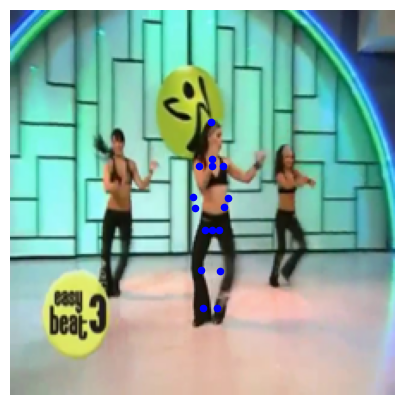

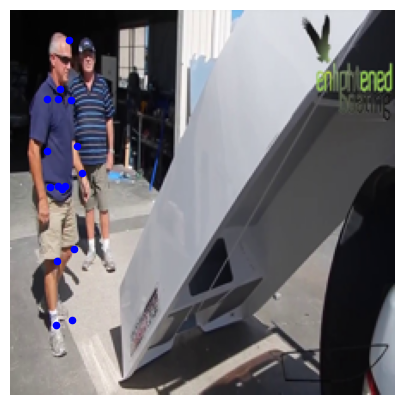

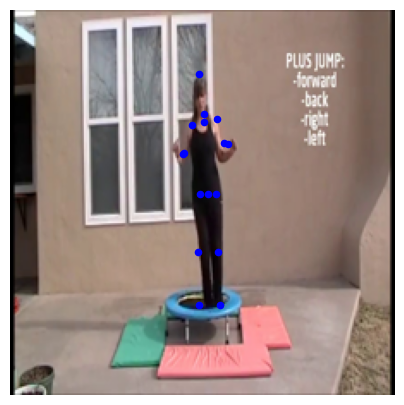

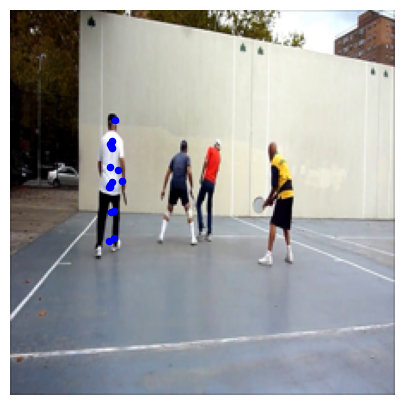

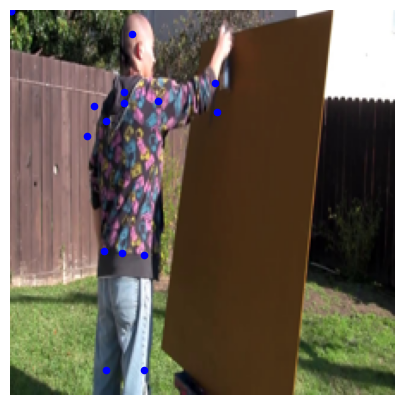

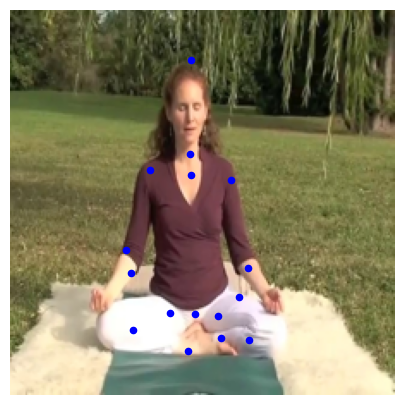

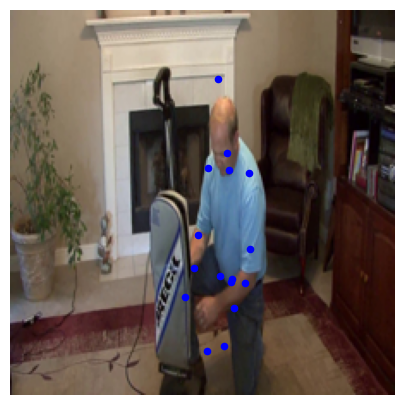

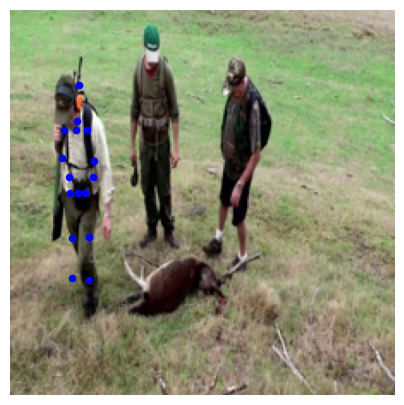

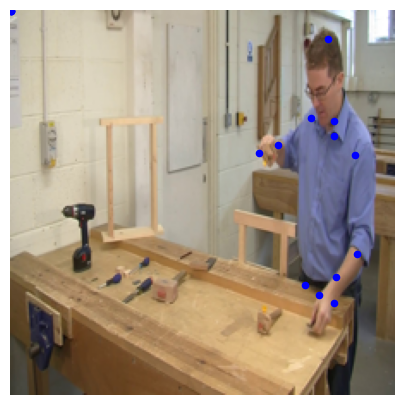

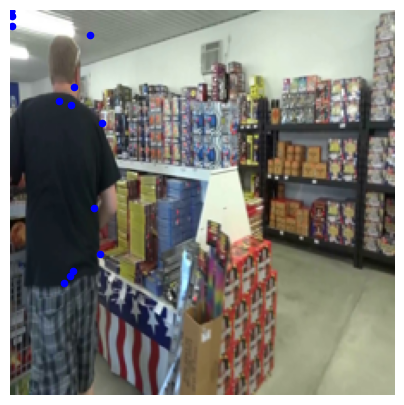

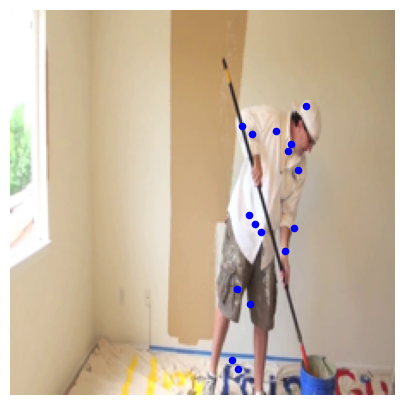

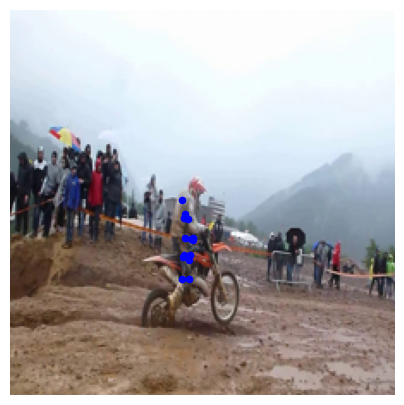

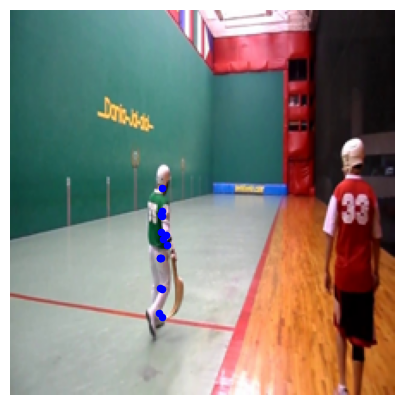

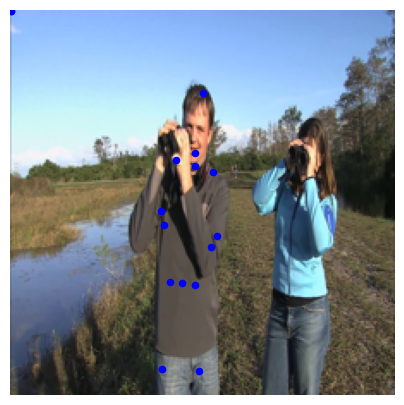

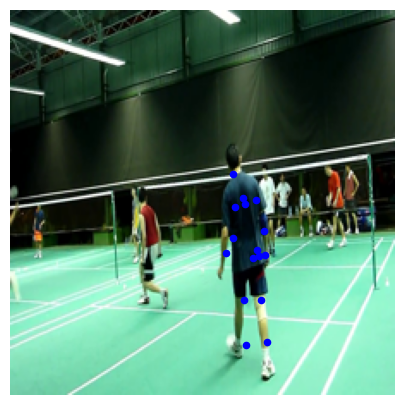

In [54]:
import matplotlib.pyplot as plt
import random
def denormalize_keypoints(keypoints, width, height):
    """Convert normalized keypoints back to pixel coordinates."""
    keypoints = keypoints.view(-1, 2)
    keypoints[:, 0] *= (width - 1)
    keypoints[:, 1] *= (height - 1)
    return keypoints

def plot_predictions(model, dataset, device, num_images=5, input_size=(224, 224)):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            image_tensor, true_keypoints = dataset[idx]
            image_input = image_tensor.unsqueeze(0).to(device)

            # Predict
            predicted_keypoints = model(image_input).cpu().squeeze()
            predicted_keypoints = denormalize_keypoints(predicted_keypoints, *input_size)

            # Convert image back to numpy for plotting
            image_np = image_tensor.permute(1, 2, 0).numpy()
            image_np = image_np.clip(0, 1)

            # Plot
            plt.figure(figsize=(5, 5))
            plt.imshow(image_np)
            plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='b', marker='o', s=20)
            plt.axis('off')
            plt.show()

device = 'cuda'
model = KeypointPredictionModel().to(device)
checkpoint_path = '/kaggle/input/cvmodel/model_epoch_50.pth'
state_dict = torch.load(checkpoint_path)
model.load_state_dict(state_dict)

plot_predictions(model, dataset, device, num_images=15, input_size=INPUT_SIZE)

# For Videos

In [11]:
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

MODEL_PATH = '/kaggle/input/cvmodel/model_epoch_50.pth'
VIDEO_PATH = '/kaggle/input/video2/video-for-pose-detection-1-1080x1920-30fps.mp4'
OUTPUT_PATH = 'output_video_3.mp4'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = KeypointPredictionModel().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

transform = transforms.Compose([
    transforms.ToTensor()
])

def process_frame(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_frame).resize((224, 224))
    tensor_img = transform(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(tensor_img)
    keypoints = outputs.squeeze().cpu().numpy() * 223
    keypoints = keypoints.reshape(-1, 2)
    keypoints[:, 0] *= width / 224
    keypoints[:, 1] *= height / 224
    return keypoints

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    keypoints = process_frame(frame)
    for x, y in keypoints:
        cv2.circle(frame, (int(x), int(y)), 10, (0, 0, 255), -1)
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Output video saved to: {OUTPUT_PATH}")

<ipython-input-11-0da4584db247>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Output video saved to: output_video_3.mp4
